In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import random

### Data Preparation

In [ ]:
def get_dataset(directory):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                temp_label = filename.split('.')[0].split('_')[0]
                if 'a' in temp_label:
                    label ='alcoholic'
                else:
                    label = 'control'

                temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                rwb = np.load(rel_path)
                rwb.astype(np.float64).reshape(-1,1)
                # print(rwb)
                # with open(rel_path, 'r') as file:
                    
                #     rwb = list(csv.reader(file, delimiter=","))[0]
                #     # scaler = preprocessing.MinMaxScaler()
                #     rwb = np.asarray(rwb).astype(np.float64).reshape(-1,1)
                #     # print(rwb)
                                
                temp_data['data'][0] = rwb
                temp_data['label'] = label
                
                # decomp = np.arange(0, 366)
                # plt.plot(decomp, df_data)
                # plt.xlabel('Dimension Number')
                # plt.ylabel('Wavelet Bispectrum Energy')
                # plt.show()
                data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"alcoholic": 1, "control": 0}
    data['label_map'] = data['label'].map(label_map)
    # print(data)      
    return data

In [ ]:
def get_batch(path):
    # loading extracted feature & label
    x = get_dataset(path)

    scaler = preprocessing.MinMaxScaler()

    series_list = [
        i for i in x["data"]
    ]

    # series_list = series_list.reshape(-1, 366, 1)

    labels_list = [i for i in x["label_map"]]
        
    # y = keras.utils.to_categorical(y[0])
    dataset = tf.data.Dataset.from_tensor_slices((series_list,labels_list))
    dataset = dataset.shuffle(len(labels_list)).batch(32)

    return dataset

In [ ]:
test = get_batch('../smni_cmi_test_bispectrum_256')
for i in test:
    print(i)

In [ ]:
del test

### Exploratory Data Analysis

[]


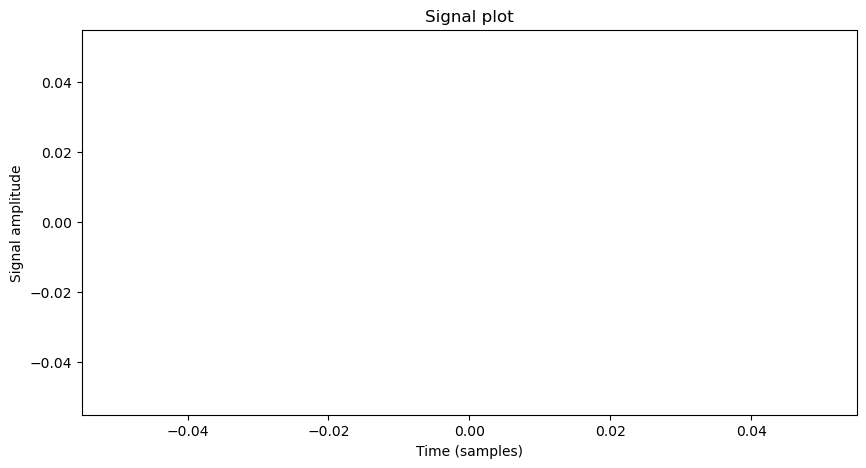

In [8]:
# Load the CSV file into a DataFrame
signal = np.load('../smni_cmi_test_bispectrum_4\co2a0000364\co2a0000364_30_bispectrum.npy')

print(signal)
# Extract the signal values from the DataFrame

# Create a time axis for the signal
t = range(len(signal))

fig, ax = plt.subplots(figsize=(10, 5))
# Plot the signal
ax.plot(t, signal)
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Signal amplitude')
ax.set_title('Signal plot')
plt.show()


### Model Definition

In [ ]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(915,)))
    model.add(layers.Reshape((915, 1)))

    model.add(layers.Conv1D(filters=16, kernel_size=4, activation="relu"))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv1D(filters=8, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Define Callbacks

In [ ]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensorboard_callback
    

### Main Program

In [ ]:
lags = [256, 128, 64, 32, 16, 8, 4, 2]
folds = ['train_1', 'test_1', 'train_2', 'test_2']
epochs = 100
log_dir = 'logs'
train_dir = '../smni_cmi_train_bispectrum'
test_dir = '../smni_cmi_train_bispectrum'

recap = pd.DataFrame(index=lags, columns=folds)

In [36]:
for fold in range(1,3):
    for lag in [256]:
        if fold == 2:
            train_dir, test_dir = test_dir, train_dir
        
        train_temp_dir = train_dir + '_' + str(lag)
        test_temp_dir = test_dir + '_' + str(lag)

        train = get_batch('../smni_cmi_test_bispectrum_256')
        test_ds = get_batch('../smni_cmi_test_bispectrum_256')

        train_size = int(len(list(train.as_numpy_iterator()))*0.8)
        train_ds = train.take(train_size)
        val_ds = train.skip(train_size)

        log_path = os.path.join(log_dir, str(fold), str(lag))

        model = create_model()
        model.summary()

        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

        history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))
        results = model.evaluate(test_ds, callbacks = myCallbacks(log_path))

        recap.loc[lag, 'train'+ '_' + str(fold)] = history.history['acc'][-1]
        recap.loc[lag, 'test'+ '_' + str(fold)] = results[1]

        model.save(os.path.join(log_path,'model.h5'))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 915, 1)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 912, 16)           80        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 228, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 228, 16)          64        
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 227, 8)            264       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 56, 8)           

In [ ]:
recap.to_csv('../Logs/Recap/recap.csv')

In [ ]:
! tensorboard --logdir logs --port=8000

In [ ]:
! cd